<img src="spam.jpg" />

# Spam Classifier

### Objectif : Concevoir un classifieur de détection automatique de SPAM.

La collection SMS Spam est un ensemble de messages SMS marqués qui ont été collectés pour la recherche sur les SMS Spam. Elle contient un ensemble de messages SMS en anglais de 5 574 messages, étiquetés selon qu'ils sont ham (légitimes) ou spam.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
#import sqlite3 as sql # Pourquoi ? Pas de sqlite dans ce projet
#import xlrd # Pourquoi ? Pas de Excel dans ce projet

In [2]:
df = pd.read_csv('spam.csv',encoding = "latin-1")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [4]:
df.drop(['Unnamed: 2', 'Unnamed: 3','Unnamed: 4'],axis=1,inplace=True)
df.rename(columns={"v1": "target", "v2": "text"},inplace=True)

In [5]:
df.head()

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
df.describe()

,target,text
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


# EDA + Preprocessing

In [7]:
df['target'].value_counts()

ham     4825
spam     747
Name: target, dtype: int64

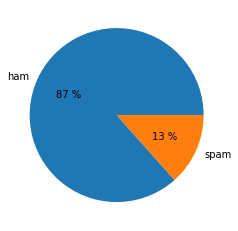

In [8]:
plt.pie(df["target"].value_counts(),labels=["ham","spam"],autopct="%.0f %%")
plt.show()

### Valeurs en double

In [9]:
df.duplicated().value_counts()

False    5169
True      403
dtype: int64

In [10]:
df.drop_duplicates(inplace=True) # (pour Noli,inplace supprimer directement sur la df)

In [11]:
df.duplicated().value_counts() # Verification apres suppression

False    5169
dtype: int64

# Features extraction

#### Longueur du texte

In [14]:
df['length'] = df['text'].str.len()

In [15]:
df.head() # Verification

,target,text,words_count,length
0,ham,"Go until jurong point, crazy.. Available only ...",20,111
1,ham,Ok lar... Joking wif u oni...,6,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,155
3,ham,U dun say so early hor... U c already then say...,11,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,61


#### Nombre de mots

In [12]:
df['words_count'] = df['text'].apply(lambda x: len(x.split(" ")))

In [13]:
df.head() # Verification

,target,text,words_count
0,ham,"Go until jurong point, crazy.. Available only ...",20
1,ham,Ok lar... Joking wif u oni...,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28
3,ham,U dun say so early hor... U c already then say...,11
4,ham,"Nah I don't think he goes to usf, he lives aro...",13


#### Nombre de majuscules

In [31]:
df['uppercases_count'] = df['text'].str.findall(r'[A-Z]').str.len()

In [32]:
df.head() # Verification

,target,text,words_count,length,uppercases_count
0,ham,"Go until jurong point, crazy.. Available only ...",20,111,3
1,ham,Ok lar... Joking wif u oni...,6,29,2
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,155,10
3,ham,U dun say so early hor... U c already then say...,11,49,2
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,61,2


#### Nombre de minuscules

In [34]:
df['lowercases_count'] = df['text'].str.findall(r'[a-z]').str.len()

In [35]:
df.head()

,target,text,words_count,length,uppercases_count,lowercases_count
0,ham,"Go until jurong point, crazy.. Available only ...",20,111,3,80
1,ham,Ok lar... Joking wif u oni...,6,29,2,16
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,155,10,87
3,ham,U dun say so early hor... U c already then say...,11,49,2,31
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,61,2,45


#### Presence d'un numéro de téléphone

In [36]:
df['phone_number'] = df['text'].str.extract('(\d{2})')

In [39]:
df.head() # Verification

,target,text,words_count,length,uppercases_count,lowercases_count,phone_number
0,ham,"Go until jurong point, crazy.. Available only ...",20,111,3,80,NaN
1,ham,Ok lar... Joking wif u oni...,6,29,2,16,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,155,10,87,21
3,ham,U dun say so early hor... U c already then say...,11,49,2,31,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,61,2,45,NaN


In [40]:
df[df['phone_number'].notna()].value_counts(df['target']=='spam')

target
True     580
False     97
dtype: int64

Text(0.5, 1.0, 'le rapport ham/spam quand il y a au mois 2 chiffres de suites')

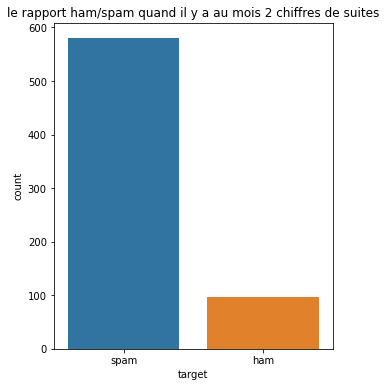

In [105]:
df1 = df[df['phone_number'].notna()]
plt.figure(figsize=(5,6), )
sns.countplot(x=df1['target']).set_title('le rapport ham/spam quand il y a au mois 2 chiffres de suites')

<font color='red'>Remarque : Sortir un booleen 1 ou 0 pour la présence d'une suite de chiffres ? </font>

#### Présence d'une url

In [65]:
def isUrlInText(txt):
    if bool(re.search("\.[a-z]{2,3}(\.|\s|$)|(https?:\/\/|www\.)[a-zA-Z0-9-_\.]+", txt)):
        return 1
    else:
        return 0

In [68]:
df['url'] = df['text'].map(isUrlInText)

In [69]:
df.head() # Verification

,target,text,words_count,length,uppercases_count,lowercases_count,phone_number,url
0,ham,"Go until jurong point, crazy.. Available only ...",20,111,3,80,NaN,0
1,ham,Ok lar... Joking wif u oni...,6,29,2,16,NaN,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,155,10,87,21,0
3,ham,U dun say so early hor... U c already then say...,11,49,2,31,NaN,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,61,2,45,NaN,0


In [78]:
df.groupby(['target'])['url'].sum()

target
ham     175
spam    116
Name: url, dtype: int64

Text(0.5, 1.0, "Rapport ham/spam si présence d'une url")

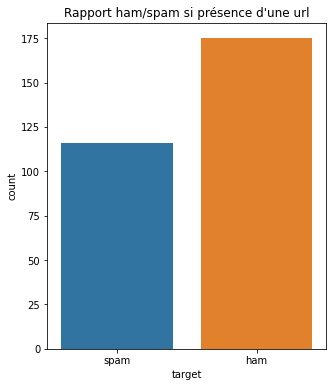

In [93]:
df1 = df[df['url'] == 1]
plt.figure(figsize=(5,6), )
sns.countplot(x=df1['target']).set_title('Rapport ham/spam si présence d\'une url')

#### Nombre de caractères spéciaux

In [101]:
def countSpecialCharInText(txt):
    return len(re.findall("[$&+:;=?@#|'<>^*()%!-]", txt))

In [99]:
df['special_char_count'] = df['text'].map(countSpecialCharInText)

In [143]:
df.head() # Verification

,target,text,words_count,length,uppercases_count,lowercases_count,phone_number,url,special_char_count
0,ham,"Go until jurong point, crazy.. Available only ...",20,111,3,80,NaN,0,9
1,ham,Ok lar... Joking wif u oni...,6,29,2,16,NaN,0,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,155,10,87,21,0,6
3,ham,U dun say so early hor... U c already then say...,11,49,2,31,NaN,0,6
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,61,2,45,NaN,0,2


Text(0.5, 1.0, 'Moyenne ham/spam des carac.spéciaux')

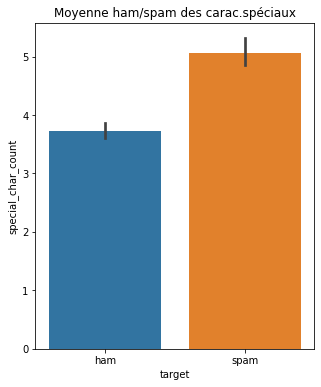

In [142]:
plt.figure(figsize=(5,6),)
sns.barplot(data = df, x="target",y="special_char_count").set_title('Moyenne ham/spam des carac.spéciaux')

#### Présence d'un mail

In [145]:
def isMainInText(txt):
    if bool(re.search("/[\w._%+-]+@[\w.-]+\.[a-zA-Z]{2,4}", txt)):
        return 1
    else:
        return 0

In [146]:
df['mail'] = df['text'].map(isMainInText)

In [147]:
df.head() # Verification

,target,text,words_count,length,uppercases_count,lowercases_count,phone_number,url,special_char_count,mail
0,ham,"Go until jurong point, crazy.. Available only ...",20,111,3,80,NaN,0,9,0
1,ham,Ok lar... Joking wif u oni...,6,29,2,16,NaN,0,6,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,155,10,87,21,0,6,0
3,ham,U dun say so early hor... U c already then say...,11,49,2,31,NaN,0,6,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,61,2,45,NaN,0,2,0
